,High,Low,Open,Close,Volume,Adj Close,MA_Fast,MA_Slow,MACD,Signal
Date,,,,,,,,,,
2020-04-28,175.669998,169.389999,175.589996,169.809998,34392700.0,169.338379,171.680532,165.057978,6.622554,8.854721
2020-04-29,177.679993,171.880005,173.220001,177.429993,51286600.0,176.937210,173.432758,165.881548,7.551210,8.588430
2020-04-30,180.399994,176.229996,180.000000,179.210007,53661300.0,178.712280,175.192599,166.766824,8.425775,8.555932
2020-05-01,178.639999,174.009995,175.800003,174.570007,39370500.0,174.085175,174.823457,167.269512,7.553945,8.359273
2020-05-04,179.000000,173.800003,174.490005,178.839996,30372900.0,178.343292,175.996736,168.026996,7.969740,8.283909
2020-05-05,183.649994,179.899994,180.619995,180.759995,36839200.0,180.257965,177.417146,168.860396,8.556750,8.336088
2020-05-06,184.199997,181.630005,182.080002,182.539993,32139300.0,182.033020,178.955770,169.754719,9.201052,8.499963
2020-05-07,184.550003,182.580002,184.169998,183.600006,28316000.0,183.090088,180.333876,170.657044,9.676832,8.721240
2020-05-08,185.000000,183.360001,184.979996,184.679993,30912600.0,184.167068,181.611607,171.568319,10.043288,8.968282


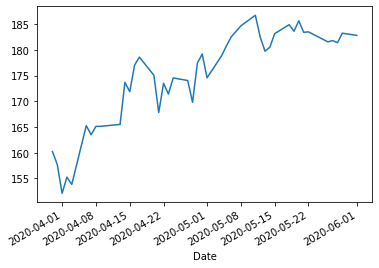

In [49]:
import pandas_datareader.data as pdr
import datetime as dt
import pandas as pd
import numpy as np
start_date = dt.datetime.now() - dt.timedelta(days=90)
end_date = dt.datetime.today()
tickers  = ['MSFT']
ohlcv = pdr.get_data_yahoo(tickers[0],start_date,end_date)
df = ohlcv.copy()
df
MACD(df,5,20,10)
MACD(df,3,10,10)["Close"].plot()
MACD(df,5,30,10)




# MACD


In [0]:
def MACD(Df,a,b,c):
    df = Df.copy()
    df['MA_Fast'] = df['Adj Close'].ewm(span = a , min_periods = a).mean()
    df['MA_Slow'] = df['Adj Close'].ewm(span = b , min_periods = b).mean()
    df['MACD'] = df['MA_Fast'] - df['MA_Slow']
    df['Signal'] = df['MACD'].ewm(span = c ,min_periods = c).mean()
    df.dropna(inplace=True)
    return df


# ATR

In [0]:
def ATR(Df,n):
    df = Df.copy()
    df['H-L'] = abs(df['High'] - df['Low'])
    df['H-PC'] = abs(df['High'] - df['Adj Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Adj Close'].shift(1))
    df['TR'] = df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2
    

## Bollinger Band

In [0]:
def BollBnd(Df,n):
    df = Df.copy()
    df['MA'] = df['Adj Close'].rolling(n).mean()
    df['BB_up'] = df['Adj Close'].rolling(n).mean() + 2*df['MA'].rolling(n).std()
    df['BB_dn'] = df['Adj Close'].rolling(n).mean() - 2*df['MA'].rolling(n).std()
    df['BB_Width'] = df['BB_up'] - df['BB_dn']
    df.dropna(inplace=True)
    return df

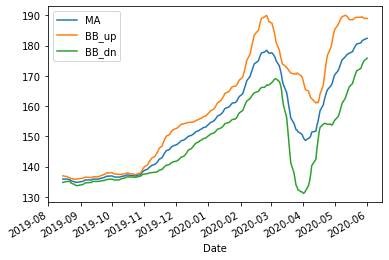

In [28]:
BollBnd(ohlcv,20).iloc[-200:,[6,7,8]].plot()

# RSI


In [0]:
def RSI(Df,n):
    df = Df.copy()
    df['delta'] = df['Adj Close'] - df['Adj Close'].shift(1)
    df['gain'] = np.where(df['delta']>=0,df['delta'],0)
    df['loss'] = np.where(df['delta']<0,abs(df['delta']),0)
    avg_gain = []
    avg_loss = []
    gain = df['gain'].tolist()
    loss = df['loss'].tolist()
    for i in range(len(df)):
        if i < n:
            avg_gain.append(np.NaN)
            avg_loss.append(np.NaN)
        elif i == n:
            avg_gain.append(df['gain'].rolling(n).mean().tolist()[n])
            avg_loss.append(df['loss'].rolling(n).mean().tolist()[n])
        elif i > n:
            avg_gain.append(((n-1)*avg_gain[i-1] + gain[i])/n)
            avg_loss.append(((n-1)*avg_loss[i-1] + loss[i])/n)
    
    df['avg_gain'] = np.array(avg_gain)
    df['avg_loss'] = np.array(avg_loss)
    df['RS'] = df['avg_gain']/df['avg_loss']
    df['RSI'] = 100 - (100/(1+df['RS']))
    return df
            

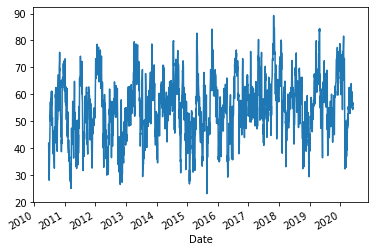

In [30]:
RSI(ohlcv,14)['RSI'].plot()

# ADX

In [0]:
def ADX(DF,n):
    "function to calculate ADX"
    df2 = DF.copy()
    df2['TR'] = ATR(df2,n)['TR'] #the period parameter of ATR function does not matter because period does not influence TR calculation
    df2['DMplus']=np.where((df2['High']-df2['High'].shift(1))>(df2['Low'].shift(1)-df2['Low']),df2['High']-df2['High'].shift(1),0)
    df2['DMplus']=np.where(df2['DMplus']<0,0,df2['DMplus'])
    df2['DMminus']=np.where((df2['Low'].shift(1)-df2['Low'])>(df2['High']-df2['High'].shift(1)),df2['Low'].shift(1)-df2['Low'],0)
    df2['DMminus']=np.where(df2['DMminus']<0,0,df2['DMminus'])
    TRn = []
    DMplusN = []
    DMminusN = []
    TR = df2['TR'].tolist()
    DMplus = df2['DMplus'].tolist()
    DMminus = df2['DMminus'].tolist()
    for i in range(len(df2)):
        if i < n:
            TRn.append(np.NaN)
            DMplusN.append(np.NaN)
            DMminusN.append(np.NaN)
        elif i == n:
            TRn.append(df2['TR'].rolling(n).sum().tolist()[n])
            DMplusN.append(df2['DMplus'].rolling(n).sum().tolist()[n])
            DMminusN.append(df2['DMminus'].rolling(n).sum().tolist()[n])
        elif i > n:
            TRn.append(TRn[i-1] - (TRn[i-1]/n) + TR[i])
            DMplusN.append(DMplusN[i-1] - (DMplusN[i-1]/n) + DMplus[i])
            DMminusN.append(DMminusN[i-1] - (DMminusN[i-1]/n) + DMminus[i])
    df2['TRn'] = np.array(TRn)
    df2['DMplusN'] = np.array(DMplusN)
    df2['DMminusN'] = np.array(DMminusN)
    df2['DIplusN']=100*(df2['DMplusN']/df2['TRn'])
    df2['DIminusN']=100*(df2['DMminusN']/df2['TRn'])
    df2['DIdiff']=abs(df2['DIplusN']-df2['DIminusN'])
    df2['DIsum']=df2['DIplusN']+df2['DIminusN']
    df2['DX']=100*(df2['DIdiff']/df2['DIsum'])
    ADX = []
    DX = df2['DX'].tolist()
    for j in range(len(df2)):
        if j < 2*n-1:
            ADX.append(np.NaN)
        elif j == 2*n-1:
            ADX.append(df2['DX'][j-n+1:j+1].mean())
        elif j > 2*n-1:
            ADX.append(((n-1)*ADX[j-1] + DX[j])/n)
    df2['ADX']=np.array(ADX)
    return df2['ADX']

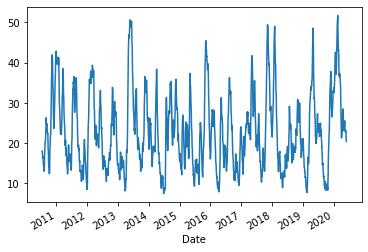

In [32]:
ADX(ohlcv,14).dropna().plot()